In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision and Time Series (Lectures 19 and 20) 

**Due date: see the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

we tested the two categorical features, type and region, region is the categorical feature for which we have separate measurements. we see that there are 54 different region values. we see great variations in the values for AveragePrice and Total Volume. for example, the mean total volume of avocados sold in Boise is 4.264257e+04 while in California it is 3.044324e+06. this is a very big difference that is probably affected by local prices and differences in units sold by region. 
We can also see by the index numbers that they start and end for each region.

In [9]:
option1 = df.sort_values(by=["type"])
option1.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
52,2017-01-01,1.15,803348.87,87695.70,531287.44,114647.36,69718.37,63550.62,1078.38,5089.37,conventional,2017,Chicago
51,2017-01-08,1.16,822522.24,79629.99,499835.88,151447.25,91609.12,81467.82,1420.05,8721.25,conventional,2017,Chicago
50,2017-01-15,1.23,776820.81,78836.36,480071.92,142550.33,75362.20,67302.01,1595.12,6465.07,conventional,2017,Chicago
49,2017-01-22,1.21,845065.66,120093.41,497235.79,136328.96,91407.50,83227.70,1680.17,6499.63,conventional,2017,Chicago


In [10]:
option2 = df.sort_values(by=["region"])
option2.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
25,2017-07-09,2.00,1883.10,38.06,187.90,0.00,1657.14,1657.14,0.00,0.0,organic,2017,Albany
24,2017-07-16,1.87,2889.03,155.10,274.95,0.00,2458.98,2458.98,0.00,0.0,organic,2017,Albany
23,2017-07-23,1.42,4233.61,93.39,93.39,0.00,4046.83,4046.83,0.00,0.0,organic,2017,Albany
22,2017-07-30,1.67,2503.82,55.26,92.99,0.00,2355.57,2355.57,0.00,0.0,organic,2017,Albany


In [11]:
df_sort = df.sort_values(by=["type", "region", "Date"])
df_sort.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
48,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
47,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany


In [12]:
df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [13]:
df["type"].unique()

array(['conventional', 'organic'], dtype=object)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

From the random regions picked below, it does seem that the data is evenly spaced out as either 0 days (multiple entries ont he same day) or 7 days apart.

In [14]:
#adapted from lec 19

def plot_time_spacing_distribution(df, region):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for Atlanta:
Date
0 days    169
7 days    168
Name: count, dtype: int64



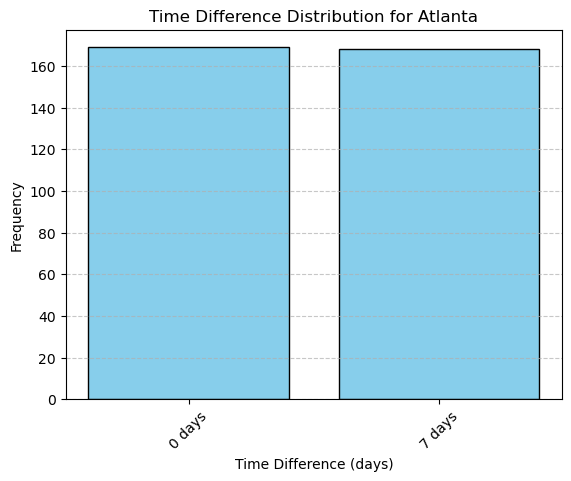

In [15]:
plot_time_spacing_distribution(df, "Atlanta")

Time spacing counts for Detroit:
Date
0 days    169
7 days    168
Name: count, dtype: int64



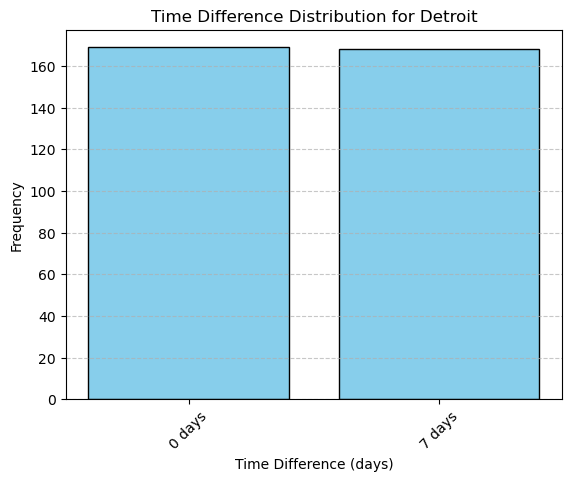

In [16]:
plot_time_spacing_distribution(df, "Detroit")

Time spacing counts for WestTexNewMexico:
Date
0 days    166
7 days    168
Name: count, dtype: int64



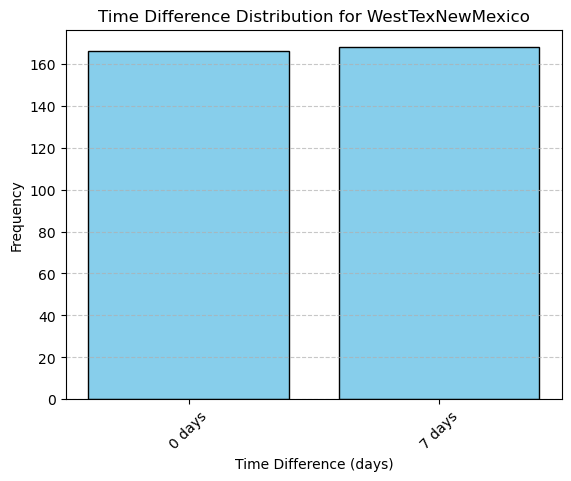

In [17]:
plot_time_spacing_distribution(df, "WestTexNewMexico")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

There are some overlaps. There are names of cities, like Detroit, Chicago, San Francisco,Las Vegas etc., but also states like California, which encompass some of the cities. There is also a TotalUS region, which covers all the cities and states above, plus potentially more. There fore there are overlaps in distinct regions

In [18]:
df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2023W1/tree/main/lectures), with some improvements.

In [19]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [20]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [21]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [22]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [23]:
from sklearn.metrics import r2_score

y_train_true = df_train['AveragePriceNextWeek']
y_train_pred = df_train['AveragePrice']

train_r2 = r2_score(y_train_true, y_train_pred)

In [24]:
train_r2

0.8285800937261841

In [25]:
y_test_true = df_test['AveragePriceNextWeek']
y_test_pred = df_test['AveragePrice']

test_r2 = r2_score(y_test_true, y_test_pred)

In [26]:
test_r2

0.7631780188583048

In [27]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

The best model is Ridge	with a training score of 0.839446 and test score of 0.805116. this indicates little to no overfitting.

In [35]:
#encoding date

y_train = df_train['AveragePriceNextWeek']
y_test = df_test['AveragePriceNextWeek']

X_train = df_train.drop(columns=['AveragePriceNextWeek'])
X_test = df_test.drop(columns=['AveragePriceNextWeek'])

X_train['date_POSIX'] = X_train['Date'].astype("int64").values.reshape(-1, 1) // 10 ** 9
X_test['date_POSIX'] = X_test['Date'].astype("int64").values.reshape(-1, 1) // 10 ** 9

X_train['day_of_year'] = X_train['Date'].dt.dayofyear
X_test['day_of_year'] = X_test['Date'].dt.dayofyear

X_train['day_of_year_sin'] = np.sin(2 * np.pi * X_train['day_of_year'] / 365.0)
X_train['day_of_year_cos'] = np.cos(2 * np.pi * X_train['day_of_year'] / 365.0)
X_test['day_of_year_sin'] = np.sin(2 * np.pi * X_test['day_of_year'] / 365.0)
X_test['day_of_year_cos'] = np.cos(2 * np.pi * X_test['day_of_year'] / 365.0)

X_train['month_sin'] = np.sin(2 * np.pi * X_train['Date'].dt.month / 12.0)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['Date'].dt.month / 12.0)
X_test['month_sin'] = np.sin(2 * np.pi * X_test['Date'].dt.month / 12.0)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['Date'].dt.month / 12.0)

X_train['week_of_year'] = X_train['Date'].dt.isocalendar().week
X_test['week_of_year'] = X_test['Date'].dt.isocalendar().week

X_train['day_of_week'] = X_train['Date'].dt.dayofweek  
X_test['day_of_week'] = X_test['Date'].dt.dayofweek  

X_train['year_progression'] = X_train['Date'].dt.year - X_train['Date'].dt.year.min()  
X_test['year_progression'] = X_test['Date'].dt.year - X_test['Date'].dt.year.min() 

In [36]:
#preprocessing

categorical_features = ['type', 'region'] 
numeric_features = ['date_POSIX', 'AveragePrice', 'day_of_year', 'month_sin', 'month_cos', 
                    'week_of_year', 'day_of_week', 'year_progression']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

results = []

In [38]:
# randomforestregressor adapted from lec 20

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

rf = RandomForestRegressor(n_estimators=100, random_state=0)

pipe_rf = make_pipeline(preprocessor, rf)

pipe_rf.fit(X_train, y_train)

y_train_pred = pipe_rf.predict(X_train)  # Predictions on the training set
y_test_pred = pipe_rf.predict(X_test)    # Predictions on the test set

train_r2 = r2_score(y_train, y_train_pred)  # R^2 for training data
test_r2 = r2_score(y_test, y_test_pred)     # R^2 for test data

results.append({
    'Model': 'RandomForestRegressor',
    'Train R2': train_r2,
    'Test R2': test_r2
})

results_df = pd.DataFrame(results)

,Model,Train R2,Test R2
0,RandomForestRegressor,0.979833,0.734874


In [39]:
#ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

ridge = Ridge()

pipe_ridge = make_pipeline(preprocessor, ridge)

tscv = TimeSeriesSplit(n_splits=5)

train_r2_total = 0
val_r2_total = 0

for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
    
    pipe_ridge.fit(X_train_split, y_train_split)
    
    y_train_pred = pipe_ridge.predict(X_train_split)
    y_val_pred = pipe_ridge.predict(X_val_split)
    
    train_r2_total += r2_score(y_train_split, y_train_pred)
    val_r2_total += r2_score(y_val_split, y_val_pred)

average_train_r2 = train_r2_total / tscv.get_n_splits()
average_val_r2 = val_r2_total / tscv.get_n_splits()

pipe_ridge.fit(X_train, y_train)
y_test_pred = pipe_ridge.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

results.append ({
    'Model': 'Ridge',
    'Train R2': average_train_r2, 
    'Test R2': test_r2
})

results_df = pd.DataFrame(results)

,Model,Train R2,Test R2
0,RandomForestRegressor,0.979833,0.734874
1,Ridge,0.839446,0.805116


In [40]:
#xgb
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=0)

pipe_xgb = make_pipeline(preprocessor, xgb)

pipe_xgb.fit(X_train, y_train)

y_train_pred = pipe_xgb.predict(X_train)
y_test_pred = pipe_xgb.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

results.append({
    'Model': 'XGBRegressor',
    'Train R2': train_r2,
    'Test R2': test_r2
})

results_df = pd.DataFrame(results)

,Model,Train R2,Test R2
0,RandomForestRegressor,0.979833,0.734874
1,Ridge,0.839446,0.805116
2,XGBRegressor,0.931343,0.747283


In [ ]:
results_df

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. stock market prices when the stock market is closed for holiday season
2. encoding the date as one or more features would struggle. the model automatically assumes date/time features to be equally spaces
3. because it is linear, so does not capture nuances in the data. it’s not able to capture the periodic pattern in the data as we have encoded time of day using integers and a linear function can only learn a linear function of the time of day. this time of day is not linear.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. (4 x 10) coefficients + 4 intercepts = 44 parameters. 1 coefficient + 1 intercept per class, plus a coefficient for each feature within each class (4 x 10)
2. Pre-trained networks learn general patterns and features in the early layers, which are broadly applicable to many different tasks. These features can then be fine-tuned for a specific task or a dataset, significantly improving performance on smaller datasets where training a model from scratch would be inefficient
3. I would use a CNN as i can fine-tune the pre-trained model on my dataset to improve performance without needing large amounts of data to train the CNN from scratch. this helps overcome the issue of not having a large training dataset



<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)